# Hate Speech Detector - EN - Convolutional model

In [1]:
import os
import pandas as pd
import csv
import glob
import numpy as np
import pickle
from klepto.archives import dir_archive
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, AvgPool2D, Flatten, Concatenate
from tensorflow.keras.layers import Lambda
from tensorflow import split
from tensorflow.keras.utils import to_categorical

from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

## Load features & labels

In [3]:
archive = dir_archive( 'hsd/Reddit/X_y_lstm', {}, cached=True)
archive.load()
first_card = archive['wt_num']
archive = None

In [4]:
# sh = features.shape
# sh

In [5]:
# features =  features.reshape(sh[0], sh[1], int(sh[2]/3), 3)
# features.shape

In [6]:
def get_data(data_path = 'hsd/Reddit/X_y_conv', test=0.3):
    archive = dir_archive(data_path, {}, cached=True)
    archive.load()

    features = archive['features']
    labels = archive['labels']
    sh = features.shape
    features =  features.reshape(sh[0], sh[1], int(sh[2]/3), 3)
    features = np.array(features)
    labels = np.array(labels)
    print(features.shape)
    print(first_card)
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size=test)

    print(Counter(y_train))
    print(Counter(y_test))

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return X_train, y_train, X_test, y_test

## Model

The best model was selected using a GridSearch with 5-fold CV.

In [7]:
# hyperparams
LAYERS = 3  # convolutional layers count
LR = 0.001  # learning rate
OPTIM = tf.keras.optimizers.Adam  # optimizer
EPOCHS = 20

# params
BATCH_SIZE = 100  # size of input batch
INIT = 'random_normal'  # trainable param initializer
CONV_FILTER = (2, 4)  # convolution filter
POOL_FILTER = (2, 4)  # pooling filter
POOL_STRIDE = (2, 4)  # pooling stride

#non-testing params
CHANNELS = 64  # convolutional layer channels
POOL = MaxPool2D  # pooling method

In [8]:
SPLIT_RATIO = 0.7

In [9]:
X_train, y_train, X_test, y_test = get_data()

(55132, 38, 40, 3)
19
Counter({0: 24690, 1: 13902})
Counter({0: 10582, 1: 5958})


In [10]:
class MetricsCallback(Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.val_f1s0 = []
        self.val_f1s1 = []
    
    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.asarray(tf.argmax(self.model.predict(X_test), axis=1))
        val_true = np.asarray(tf.argmax(y_test, axis=1))
        c_m = confusion_matrix(val_true, val_predict, labels=[0, 1])
        self.val_f1s0.append(2*float(c_m[0][0])/(2*float(c_m[0][0]) + c_m[0][1] + c_m[1][0]))
        self.val_f1s1.append(2*float(c_m[1][1])/(2*float(c_m[1][1]) + c_m[1][0] + c_m[0][1]))

In [11]:
class ConvModel():
    def __init__(self, wt_card, input_shape, name='conv_model', **kwargs):
        self.wt_card = wt_card
        
        # hyperparams
        self.layers = LAYERS if 'layers' not in kwargs else kwargs['layers']
        self.lr = LR if 'lr' not in kwargs else kwargs['lr']
        self.optim = OPTIM(learning_rate=self.lr) if 'optim' not in kwargs else kwargs['optim'](learning_rate=self.lr)
        self.epochs = EPOCHS if 'epochs' not in kwargs else kwargs['epochs']
        
        # params
        self.batch_size = BATCH_SIZE if 'batch_size' not in kwargs else kwargs['batch_size']
        self.init = INIT if 'init' not in kwargs else kwargs['init']
        self.channels = CHANNELS if 'channels' not in kwargs else kwargs['channels']
        self.conv_filter = CONV_FILTER if 'conv_filter' not in kwargs else kwargs['conv_filter']
        self.pool_filter = POOL_FILTER if 'pool_filter' not in kwargs else kwargs['pool_filter']
        self.pool_stride = POOL_STRIDE if 'pool_stride' not in kwargs else kwargs['pool_stride']
        self.pool = POOL if 'pool' not in kwargs else kwargs['pool']
        
        # layers
        inputs = Input(shape=input_shape, name='features')
        wt_inputs, pos_inputs = Lambda(lambda x: split(x, [self.wt_card, x.shape[1] - self.wt_card], axis=1), name='wt_pos_split')(inputs)
        
        x1 = Conv2D(self.channels, kernel_size = self.conv_filter,
                    activation='relu', name='wt_conv_1',
                    kernel_initializer = self.init, bias_initializer = self.init)(wt_inputs)
        x2 = Conv2D(self.channels, kernel_size = self.conv_filter,
                    activation='relu', name='pos_conv_1',
                    kernel_initializer = self.init, bias_initializer = self.init)(pos_inputs)
#         for layer in range(self.layers)[1:]:
#             x1 = Conv2D(self.channels, kernel_size = self.conv_filter,
#                         activation='relu', name='wt_conv_{}'.format(layer+1),
#                         kernel_initializer = self.init, bias_initializer = self.init)(x1)
#             x2 = Conv2D(self.channels, kernel_size = self.conv_filter,
#                         activation='relu', name='pos_conv_{}'.format(layer+1),
#                         kernel_initializer = self.init, bias_initializer = self.init)(x2)
        
        x1 = self.pool(pool_size=self.pool_filter, strides=self.pool_stride, name='wt_pool')(x1)
        x2 = self.pool(pool_size=self.pool_filter, strides=self.pool_stride, name='pos_pool')(x2)
        
        x1 = Flatten(name='wt_flatten')(x1)
        x2 = Flatten(name='pos_flatten')(x2)
        
        x = Concatenate(axis=1, name='concatenation')([x1, x2])
        
        x = Dense(64, activation='relu', name='dense_1',
                  kernel_initializer='random_normal', bias_initializer='random_normal')(x)
        x = Dense(64, activation='relu', name='dense_2',
                  kernel_initializer='random_normal', bias_initializer='random_normal')(x)
        outputs = Dense(2, activation='softmax', name='predictions',
                        kernel_initializer='random_normal', bias_initializer='random_normal')(x)
        
        self.name = name
        self.model = Model(inputs=inputs, outputs=outputs, name=name)
        self.mc = MetricsCallback()
    
    def summary(self):
        return self.model.summary()
    
    def compile(self):
        self.model.compile(optimizer=self.optim,
                           loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    def fit(self, X_tr, y_tr, X_ev, y_ev):
        return self.model.fit(X_tr, y_tr, batch_size=self.batch_size, epochs=self.epochs,
                              validation_data=(X_ev, y_ev), callbacks=[self.mc])
    
    def predict(self, X_t):
        return self.model.predict(X_t)
    
    def save(self, file_name):
        self.model.save(file_name)

In [12]:
def models_comparison_bars(df, title, interval=2, save_file=None):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    
    labels = [i+1 if i%interval == 0 else '' for i in range(len(df))]
    x = range(len(labels))
    acc = df['acc'].values
    f1s0 = df['f1s0'].values
    f1s1 = df['f1s1'].values
    
    max_acc_id = np.argmax(acc)
    max_f1s0_id = np.argmax(f1s0)
    max_f1s1_id = np.argmax(f1s1)
    
    axs[0].bar(x, acc, color='r')
    axs[0].set_xlabel('Model number')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(labels)
    axs[0].set_ylim([0, 1])
    axs[0].set_title('Accuracy | max ({}) at: {}'.format(np.round(np.max(acc), 2), max_acc_id+1))
    axs[0].patches[max_acc_id].set_facecolor('g')
    
    axs[1].bar(x, f1s0, color='b')
    axs[1].set_xlabel('Model number')
    axs[1].set_ylabel('F1 score (no hate)')
    axs[1].set_title('F1 score (no hate) | max ({}) at: {}'.format(np.round(np.max(f1s0), 2), max_f1s0_id+1))
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(labels)
    axs[1].set_ylim([0, 1])
    axs[1].patches[max_f1s0_id].set_facecolor('g')
    
    axs[2].bar(x, f1s1, color='m')
    axs[2].set_xlabel('Model number')
    axs[2].set_ylabel('F1 score (hate speech)')
    axs[2].set_title('F1 score (hate speech) | max ({}) at: {}'.format(np.round(np.max(f1s1), 2),
                                                                       max_f1s1_id+1))
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(labels)
    axs[2].set_ylim([0, 1])
    axs[2].patches[max_f1s1_id].set_facecolor('g')
    
    fig.suptitle(title)
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

## Model hyperparams researching

In [13]:
def get_hyperparams_options(layers_options = [2, 3, 4, 5], lr_options = [0.01, 0.001],
                            optim_options = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD],
                            epochs_options = [5, 10, 15]):
    hp_options = []
    for epochs in [epochs_options[-1]]:  # changed to process 15 epochs (eval. after each 5)
        for lr in lr_options:
            for optim in optim_options:
                for layer in layers_options:
                    hp_options.append({'lr': lr, 'optim': optim, 'epochs': epochs, 'layers': layer})
    return hp_options

In [21]:
def find_hyper_parameters(options, shape, save_path = 'results/en_conv/hyperparams_research.csv', epochs_options = [5, 10, 15]):    
    if not os.path.exists(save_path):
        hp_results = []
        for i, opts in enumerate(options):
            print('\nResearching for {}/{} | Hyperparams: {}\n'.format(i+1, len(hp_options), opts))

            hp_model = ConvModel(wt_card=first_card, input_shape=shape, **opts)
            hp_model.compile()
            hp_history = hp_model.fit(X_train, y_train, X_test, y_test)

            # append means for 5, 10 and 15 epochs
            for eps in epochs_options:
                hp_results.append({'acc': np.mean(hp_history.history['categorical_accuracy'][:eps]),
                                   'val_acc': np.mean(hp_history.history['val_categorical_accuracy'][:eps]),
                                   'loss': np.mean(hp_history.history['val_loss'][:eps]),
                                   'f1s0': np.mean(hp_model.mc.val_f1s0[:eps]),
                                   'f1s1': np.mean(hp_model.mc.val_f1s1[:eps])})

        hp_results_df = pd.DataFrame(hp_results)
        hp_results_df.to_csv(save_path)
    else:
        hp_results_df = pd.read_csv(save_path, index_col=0)
    return hp_results_df

In [22]:
hp_options = get_hyperparams_options()
hp_results_df = find_hyper_parameters(options = hp_options, shape=(38, 40, 3, ))

In [23]:
pd.DataFrame(hp_options).head()

,lr,optim,epochs,layers
0,0.01,<class 'tensorflow.python.keras.optimizer_v2.a...,15,2
1,0.01,<class 'tensorflow.python.keras.optimizer_v2.a...,15,3
2,0.01,<class 'tensorflow.python.keras.optimizer_v2.a...,15,4
3,0.01,<class 'tensorflow.python.keras.optimizer_v2.a...,15,5
4,0.01,<class 'tensorflow.python.keras.optimizer_v2.g...,15,2


In [24]:
hp_results_df.head()

,acc,val_acc,loss,f1s0,f1s1
0,0.869273,0.868863,0.329528,0.902428,0.799861
1,0.871637,0.869927,0.324360,0.902834,0.803134
2,0.873706,0.869802,0.322733,0.902893,0.802347
3,0.870025,0.869274,0.321560,0.902020,0.803464
4,0.872352,0.870133,0.318069,0.902984,0.803528


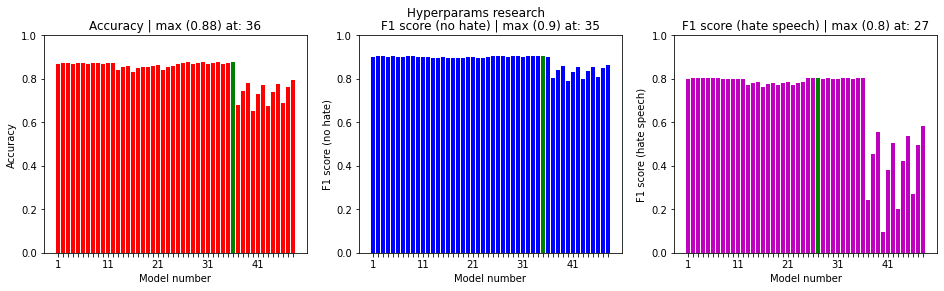

In [25]:
models_comparison_bars(hp_results_df, title='Hyperparams research', interval=10,
                       save_file='results/en_conv/hyperparams_research.png')

In [26]:
best_h_num = 42
'Best one: {} with {} run epochs'.format(hp_options[int((best_h_num-1)/3)],
                                         ((best_h_num-1)%3)*5 if (best_h_num-1)%3 != 0 else 15)

"Best one: {'lr': 0.001, 'optim': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>, 'epochs': 15, 'layers': 3} with 10 run epochs"

## Model params researching

In [27]:
batch_size_options = [100, 200]
init_options = ['random_uniform', 'random_normal']
conv_filter_options = [(1, 2), (2, 4)]
pool_filter_options = [(1, 2), (2, 4)]
pool_stride_options = [(1, 2), (2, 4)]

p_options = []
for batch_size in batch_size_options:
    for init in init_options:
        for conv_filter in conv_filter_options:
            for pool_filter in pool_filter_options:
                for pool_stride in pool_stride_options:
                    p_options.append({'batch_size': batch_size,
                                      'init': init,
                                      'conv_filter': conv_filter,
                                      'pool_filter': pool_filter,
                                      'pool_stride': pool_stride})

In [28]:
pd.DataFrame(p_options).head()

,batch_size,init,conv_filter,pool_filter,pool_stride
0,100,random_uniform,"(1, 2)","(1, 2)","(1, 2)"
1,100,random_uniform,"(1, 2)","(1, 2)","(2, 4)"
2,100,random_uniform,"(1, 2)","(2, 4)","(1, 2)"
3,100,random_uniform,"(1, 2)","(2, 4)","(2, 4)"
4,100,random_uniform,"(2, 4)","(1, 2)","(1, 2)"


In [29]:
if not os.path.exists('results/en_conv/params_research.csv'):
    p_results = []
    for i, opts in enumerate(p_options):
        print('\nResearching for {}/{} | Params: {}\n'.format(i+1, len(p_options), opts))

        p_model = ConvModel(wt_card=first_card, input_shape=(38, 40, 3), **opts)
        p_model.compile()
        p_history = p_model.fit(X_train, y_train, X_test, y_test)

        p_results.append({'acc': np.mean(p_history.history['categorical_accuracy']),
                          'val_acc': np.mean(p_history.history['val_categorical_accuracy']),
                          'loss': np.mean(p_history.history['val_loss']),
                          'f1s0': np.mean(p_model.mc.val_f1s0),
                          'f1s1': np.mean(p_model.mc.val_f1s1)})
    
    p_results_df = pd.DataFrame(p_results)
    p_results_df.to_csv('results/en_conv/params_research.csv')
else:
    p_results_df = pd.read_csv('results/en_conv/params_research.csv', index_col=0)


Researching for 1/32 | Params: {'batch_size': 100, 'init': 'random_uniform', 'conv_filter': (1, 2), 'pool_filter': (1, 2), 'pool_stride': (1, 2)}

Epoch 1/20
386/386 [==============================] - 3s 8ms/step - loss: 0.3913 - categorical_accuracy: 0.8402 - val_loss: 0.3229 - val_categorical_accuracy: 0.8667
Epoch 2/20
386/386 [==============================] - 3s 7ms/step - loss: 0.3155 - categorical_accuracy: 0.8703 - val_loss: 0.3122 - val_categorical_accuracy: 0.8718
Epoch 3/20
386/386 [==============================] - 3s 8ms/step - loss: 0.3047 - categorical_accuracy: 0.8772 - val_loss: 0.3119 - val_categorical_accuracy: 0.8697
Epoch 4/20
386/386 [==============================] - 3s 7ms/step - loss: 0.3041 - categorical_accuracy: 0.8769 - val_loss: 0.3115 - val_categorical_accuracy: 0.8710
Epoch 5/20
386/386 [==============================] - 3s 7ms/step - loss: 0.3024 - categorical_accuracy: 0.8761 - val_loss: 0.3138 - val_categorical_accuracy: 0.8718
Epoch 6/20
386/386 [==

386/386 [==============================] - 3s 8ms/step - loss: 0.3079 - categorical_accuracy: 0.8751 - val_loss: 0.3117 - val_categorical_accuracy: 0.8702
Epoch 8/20
386/386 [==============================] - 3s 8ms/step - loss: 0.3063 - categorical_accuracy: 0.8749 - val_loss: 0.3150 - val_categorical_accuracy: 0.8689
Epoch 9/20
386/386 [==============================] - 3s 8ms/step - loss: 0.3069 - categorical_accuracy: 0.8720 - val_loss: 0.3148 - val_categorical_accuracy: 0.8704
Epoch 10/20
386/386 [==============================] - 3s 8ms/step - loss: 0.2983 - categorical_accuracy: 0.8756 - val_loss: 0.3173 - val_categorical_accuracy: 0.8692
Epoch 11/20
386/386 [==============================] - 3s 8ms/step - loss: 0.2992 - categorical_accuracy: 0.8759 - val_loss: 0.3200 - val_categorical_accuracy: 0.8703
Epoch 12/20
386/386 [==============================] - 3s 8ms/step - loss: 0.3002 - categorical_accuracy: 0.8744 - val_loss: 0.3124 - val_categorical_accuracy: 0.8702
Epoch 13/20


386/386 [==============================] - 3s 7ms/step - loss: 0.1798 - categorical_accuracy: 0.9209 - val_loss: 0.4544 - val_categorical_accuracy: 0.8461
Epoch 15/20
386/386 [==============================] - 3s 7ms/step - loss: 0.1608 - categorical_accuracy: 0.9313 - val_loss: 0.5022 - val_categorical_accuracy: 0.8469
Epoch 16/20
386/386 [==============================] - 3s 7ms/step - loss: 0.1344 - categorical_accuracy: 0.9448 - val_loss: 0.5177 - val_categorical_accuracy: 0.8403
Epoch 17/20
386/386 [==============================] - 3s 7ms/step - loss: 0.1179 - categorical_accuracy: 0.9521 - val_loss: 0.5752 - val_categorical_accuracy: 0.8374
Epoch 18/20
386/386 [==============================] - 3s 7ms/step - loss: 0.1026 - categorical_accuracy: 0.9595 - val_loss: 0.6600 - val_categorical_accuracy: 0.8398
Epoch 19/20
386/386 [==============================] - 3s 7ms/step - loss: 0.0876 - categorical_accuracy: 0.9666 - val_loss: 0.7560 - val_categorical_accuracy: 0.8384
Epoch 20/2

Epoch 1/20
386/386 [==============================] - 3s 6ms/step - loss: 0.3930 - categorical_accuracy: 0.8443 - val_loss: 0.3248 - val_categorical_accuracy: 0.8671
Epoch 2/20
386/386 [==============================] - 2s 5ms/step - loss: 0.3226 - categorical_accuracy: 0.8715 - val_loss: 0.3148 - val_categorical_accuracy: 0.8707
Epoch 3/20
386/386 [==============================] - 2s 5ms/step - loss: 0.3103 - categorical_accuracy: 0.8749 - val_loss: 0.3153 - val_categorical_accuracy: 0.8694
Epoch 4/20
386/386 [==============================] - 2s 5ms/step - loss: 0.3142 - categorical_accuracy: 0.8710 - val_loss: 0.3129 - val_categorical_accuracy: 0.8688
Epoch 5/20
386/386 [==============================] - 2s 5ms/step - loss: 0.3088 - categorical_accuracy: 0.8734 - val_loss: 0.3126 - val_categorical_accuracy: 0.8707
Epoch 6/20
386/386 [==============================] - 2s 6ms/step - loss: 0.3002 - categorical_accuracy: 0.8786 - val_loss: 0.3101 - val_categorical_accuracy: 0.8722
Epoc

386/386 [==============================] - 2s 5ms/step - loss: 0.4595 - categorical_accuracy: 0.7887 - val_loss: 0.4652 - val_categorical_accuracy: 0.7858
Epoch 9/20
386/386 [==============================] - 2s 6ms/step - loss: 0.4550 - categorical_accuracy: 0.7906 - val_loss: 0.4650 - val_categorical_accuracy: 0.7859
Epoch 10/20
386/386 [==============================] - 2s 6ms/step - loss: 0.4513 - categorical_accuracy: 0.7899 - val_loss: 0.4659 - val_categorical_accuracy: 0.7855
Epoch 11/20
386/386 [==============================] - 2s 5ms/step - loss: 0.4469 - categorical_accuracy: 0.7906 - val_loss: 0.4675 - val_categorical_accuracy: 0.7852
Epoch 12/20
386/386 [==============================] - 2s 5ms/step - loss: 0.4404 - categorical_accuracy: 0.7949 - val_loss: 0.4774 - val_categorical_accuracy: 0.7833
Epoch 13/20
386/386 [==============================] - 2s 5ms/step - loss: 0.4377 - categorical_accuracy: 0.7966 - val_loss: 0.4745 - val_categorical_accuracy: 0.7867
Epoch 14/20

386/386 [==============================] - 2s 6ms/step - loss: 0.2984 - categorical_accuracy: 0.8739 - val_loss: 0.3194 - val_categorical_accuracy: 0.8671
Epoch 16/20
386/386 [==============================] - 2s 6ms/step - loss: 0.2933 - categorical_accuracy: 0.8775 - val_loss: 0.3227 - val_categorical_accuracy: 0.8669
Epoch 17/20
386/386 [==============================] - 2s 6ms/step - loss: 0.3003 - categorical_accuracy: 0.8746 - val_loss: 0.3318 - val_categorical_accuracy: 0.8674
Epoch 18/20
386/386 [==============================] - 2s 6ms/step - loss: 0.2938 - categorical_accuracy: 0.8749 - val_loss: 0.3247 - val_categorical_accuracy: 0.8672
Epoch 19/20
386/386 [==============================] - 2s 5ms/step - loss: 0.2919 - categorical_accuracy: 0.8767 - val_loss: 0.3327 - val_categorical_accuracy: 0.8660
Epoch 20/20
386/386 [==============================] - 2s 5ms/step - loss: 0.2830 - categorical_accuracy: 0.8790 - val_loss: 0.3387 - val_categorical_accuracy: 0.8640

Researchi

386/386 [==============================] - 3s 8ms/step - loss: 0.3771 - categorical_accuracy: 0.8532 - val_loss: 0.3266 - val_categorical_accuracy: 0.8673
Epoch 2/20
386/386 [==============================] - 3s 7ms/step - loss: 0.3217 - categorical_accuracy: 0.8701 - val_loss: 0.3152 - val_categorical_accuracy: 0.8716
Epoch 3/20
386/386 [==============================] - 3s 8ms/step - loss: 0.3114 - categorical_accuracy: 0.8731 - val_loss: 0.3191 - val_categorical_accuracy: 0.8701
Epoch 4/20
386/386 [==============================] - 3s 7ms/step - loss: 0.3100 - categorical_accuracy: 0.8741 - val_loss: 0.3118 - val_categorical_accuracy: 0.8716
Epoch 5/20
386/386 [==============================] - 3s 7ms/step - loss: 0.3035 - categorical_accuracy: 0.8747 - val_loss: 0.3118 - val_categorical_accuracy: 0.8691
Epoch 6/20
386/386 [==============================] - 3s 7ms/step - loss: 0.3030 - categorical_accuracy: 0.8755 - val_loss: 0.3122 - val_categorical_accuracy: 0.8714
Epoch 7/20
386/

193/193 [==============================] - 2s 12ms/step - loss: 0.2926 - categorical_accuracy: 0.8767 - val_loss: 0.3152 - val_categorical_accuracy: 0.8717
Epoch 9/20
193/193 [==============================] - 2s 12ms/step - loss: 0.2893 - categorical_accuracy: 0.8806 - val_loss: 0.3084 - val_categorical_accuracy: 0.8713
Epoch 10/20
193/193 [==============================] - 2s 12ms/step - loss: 0.2900 - categorical_accuracy: 0.8787 - val_loss: 0.3079 - val_categorical_accuracy: 0.8727
Epoch 11/20
193/193 [==============================] - 2s 12ms/step - loss: 0.2853 - categorical_accuracy: 0.8802 - val_loss: 0.3110 - val_categorical_accuracy: 0.8718
Epoch 12/20
193/193 [==============================] - 2s 12ms/step - loss: 0.2781 - categorical_accuracy: 0.8844 - val_loss: 0.3142 - val_categorical_accuracy: 0.8721
Epoch 13/20
193/193 [==============================] - 2s 12ms/step - loss: 0.2786 - categorical_accuracy: 0.8820 - val_loss: 0.3227 - val_categorical_accuracy: 0.8683
Epoch

193/193 [==============================] - 2s 13ms/step - loss: 0.2843 - categorical_accuracy: 0.8796 - val_loss: 0.3198 - val_categorical_accuracy: 0.8690
Epoch 16/20
193/193 [==============================] - 2s 13ms/step - loss: 0.2830 - categorical_accuracy: 0.8794 - val_loss: 0.3213 - val_categorical_accuracy: 0.8674
Epoch 17/20
193/193 [==============================] - 2s 13ms/step - loss: 0.2807 - categorical_accuracy: 0.8809 - val_loss: 0.3257 - val_categorical_accuracy: 0.8672
Epoch 18/20
193/193 [==============================] - 2s 13ms/step - loss: 0.2738 - categorical_accuracy: 0.8819 - val_loss: 0.3264 - val_categorical_accuracy: 0.8666
Epoch 19/20
193/193 [==============================] - 3s 13ms/step - loss: 0.2738 - categorical_accuracy: 0.8801 - val_loss: 0.3329 - val_categorical_accuracy: 0.8666
Epoch 20/20
193/193 [==============================] - 3s 13ms/step - loss: 0.2659 - categorical_accuracy: 0.8850 - val_loss: 0.3347 - val_categorical_accuracy: 0.8635

Res

193/193 [==============================] - 2s 9ms/step - loss: 0.4263 - categorical_accuracy: 0.8072 - val_loss: 0.3323 - val_categorical_accuracy: 0.8637
Epoch 2/20
193/193 [==============================] - 2s 8ms/step - loss: 0.3295 - categorical_accuracy: 0.8645 - val_loss: 0.3184 - val_categorical_accuracy: 0.8687
Epoch 3/20
193/193 [==============================] - 2s 9ms/step - loss: 0.3166 - categorical_accuracy: 0.8695 - val_loss: 0.3165 - val_categorical_accuracy: 0.8701
Epoch 4/20
193/193 [==============================] - 2s 9ms/step - loss: 0.3174 - categorical_accuracy: 0.8678 - val_loss: 0.3214 - val_categorical_accuracy: 0.8675
Epoch 5/20
193/193 [==============================] - 2s 8ms/step - loss: 0.3080 - categorical_accuracy: 0.8715 - val_loss: 0.3143 - val_categorical_accuracy: 0.8699
Epoch 6/20
193/193 [==============================] - 2s 8ms/step - loss: 0.3007 - categorical_accuracy: 0.8728 - val_loss: 0.3122 - val_categorical_accuracy: 0.8707
Epoch 7/20
193/

193/193 [==============================] - 2s 9ms/step - loss: 0.3029 - categorical_accuracy: 0.8733 - val_loss: 0.3125 - val_categorical_accuracy: 0.8709
Epoch 9/20
193/193 [==============================] - 2s 8ms/step - loss: 0.2956 - categorical_accuracy: 0.8779 - val_loss: 0.3126 - val_categorical_accuracy: 0.8707
Epoch 10/20
193/193 [==============================] - 2s 8ms/step - loss: 0.2930 - categorical_accuracy: 0.8779 - val_loss: 0.3145 - val_categorical_accuracy: 0.8701
Epoch 11/20
193/193 [==============================] - 2s 9ms/step - loss: 0.2931 - categorical_accuracy: 0.8792 - val_loss: 0.3194 - val_categorical_accuracy: 0.8693
Epoch 12/20
193/193 [==============================] - 2s 9ms/step - loss: 0.2878 - categorical_accuracy: 0.8815 - val_loss: 0.3137 - val_categorical_accuracy: 0.8726
Epoch 13/20
193/193 [==============================] - 2s 8ms/step - loss: 0.2926 - categorical_accuracy: 0.8772 - val_loss: 0.3194 - val_categorical_accuracy: 0.8701
Epoch 14/20

Epoch 14/20
193/193 [==============================] - 2s 9ms/step - loss: 0.4518 - categorical_accuracy: 0.7876 - val_loss: 0.4722 - val_categorical_accuracy: 0.7873
Epoch 15/20
193/193 [==============================] - 2s 9ms/step - loss: 0.4456 - categorical_accuracy: 0.7919 - val_loss: 0.4690 - val_categorical_accuracy: 0.7857
Epoch 16/20
193/193 [==============================] - 2s 9ms/step - loss: 0.4393 - categorical_accuracy: 0.7936 - val_loss: 0.4725 - val_categorical_accuracy: 0.7846
Epoch 17/20
193/193 [==============================] - 2s 9ms/step - loss: 0.4377 - categorical_accuracy: 0.7928 - val_loss: 0.4774 - val_categorical_accuracy: 0.7831
Epoch 18/20
193/193 [==============================] - 2s 9ms/step - loss: 0.4330 - categorical_accuracy: 0.7976 - val_loss: 0.4741 - val_categorical_accuracy: 0.7852
Epoch 19/20
193/193 [==============================] - 2s 9ms/step - loss: 0.4186 - categorical_accuracy: 0.8037 - val_loss: 0.4811 - val_categorical_accuracy: 0.776

193/193 [==============================] - 2s 9ms/step - loss: 0.3031 - categorical_accuracy: 0.8716 - val_loss: 0.3214 - val_categorical_accuracy: 0.8680
Epoch 20/20
193/193 [==============================] - 2s 9ms/step - loss: 0.2980 - categorical_accuracy: 0.8749 - val_loss: 0.3204 - val_categorical_accuracy: 0.8677

Researching for 29/32 | Params: {'batch_size': 200, 'init': 'random_normal', 'conv_filter': (2, 4), 'pool_filter': (1, 2), 'pool_stride': (1, 2)}

Epoch 1/20
193/193 [==============================] - 3s 13ms/step - loss: 0.3776 - categorical_accuracy: 0.8454 - val_loss: 0.3215 - val_categorical_accuracy: 0.8703
Epoch 2/20
193/193 [==============================] - 2s 11ms/step - loss: 0.3134 - categorical_accuracy: 0.8712 - val_loss: 0.3149 - val_categorical_accuracy: 0.8723
Epoch 3/20
193/193 [==============================] - 2s 12ms/step - loss: 0.3071 - categorical_accuracy: 0.8739 - val_loss: 0.3114 - val_categorical_accuracy: 0.8709
Epoch 4/20
193/193 [=========

193/193 [==============================] - 2s 12ms/step - loss: 0.3117 - categorical_accuracy: 0.8702 - val_loss: 0.3111 - val_categorical_accuracy: 0.8716
Epoch 6/20
193/193 [==============================] - 2s 12ms/step - loss: 0.3018 - categorical_accuracy: 0.8751 - val_loss: 0.3094 - val_categorical_accuracy: 0.8723
Epoch 7/20
193/193 [==============================] - 2s 12ms/step - loss: 0.2985 - categorical_accuracy: 0.8768 - val_loss: 0.3124 - val_categorical_accuracy: 0.8712
Epoch 8/20
193/193 [==============================] - 2s 12ms/step - loss: 0.2990 - categorical_accuracy: 0.8760 - val_loss: 0.3104 - val_categorical_accuracy: 0.8701
Epoch 9/20
193/193 [==============================] - 2s 12ms/step - loss: 0.2969 - categorical_accuracy: 0.8764 - val_loss: 0.3183 - val_categorical_accuracy: 0.8719
Epoch 10/20
193/193 [==============================] - 2s 12ms/step - loss: 0.2894 - categorical_accuracy: 0.8807 - val_loss: 0.3172 - val_categorical_accuracy: 0.8689
Epoch 11

In [30]:
p_results_df.head()

,acc,val_acc,loss,f1s0,f1s1
0,0.890441,0.863697,0.352524,0.896641,0.799683
1,0.791962,0.782839,0.476252,0.843503,0.644476
2,0.875713,0.867775,0.321390,0.901332,0.799486
3,0.870717,0.866146,0.325015,0.900307,0.796203
4,0.905484,0.859329,0.427566,0.892972,0.794481


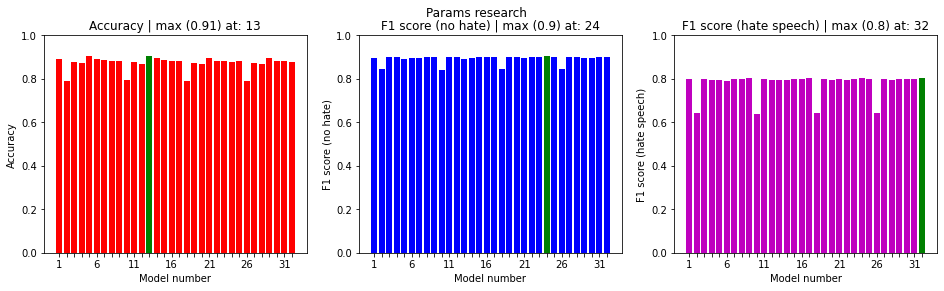

In [31]:
models_comparison_bars(p_results_df, title='Params research', interval=5,
                       save_file='results/en_conv/params_research.png')

In [32]:
best_num = 32
'Best one: {}'.format(p_options[best_num-1])

"Best one: {'batch_size': 200, 'init': 'random_normal', 'conv_filter': (2, 4), 'pool_filter': (2, 4), 'pool_stride': (2, 4)}"

## Best model

In [33]:
model = ConvModel(wt_card=first_card, input_shape=(38, 40, 3, ))
model.summary()

Model: "conv_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features (InputLayer)           [(None, 38, 40, 3)]  0                                            
__________________________________________________________________________________________________
wt_pos_split (Lambda)           [(None, 19, 40, 3),  0           features[0][0]                   
__________________________________________________________________________________________________
wt_conv_1 (Conv2D)              (None, 18, 37, 64)   1600        wt_pos_split[0][0]               
__________________________________________________________________________________________________
pos_conv_1 (Conv2D)             (None, 18, 37, 64)   1600        wt_pos_split[0][1]               
_________________________________________________________________________________________

In [34]:
model.compile()
history = model.fit(X_train, y_train, X_test, y_test)
model.save('models/en_conv.model')

Epoch 1/20
386/386 [==============================] - 3s 6ms/step - loss: 0.3838 - categorical_accuracy: 0.8504 - val_loss: 0.3214 - val_categorical_accuracy: 0.8689
Epoch 2/20
386/386 [==============================] - 2s 5ms/step - loss: 0.3208 - categorical_accuracy: 0.8694 - val_loss: 0.3153 - val_categorical_accuracy: 0.8687
Epoch 3/20
386/386 [==============================] - 2s 5ms/step - loss: 0.3155 - categorical_accuracy: 0.8725 - val_loss: 0.3139 - val_categorical_accuracy: 0.8727
Epoch 4/20
386/386 [==============================] - 2s 6ms/step - loss: 0.3007 - categorical_accuracy: 0.8796 - val_loss: 0.3229 - val_categorical_accuracy: 0.8725
Epoch 5/20
386/386 [==============================] - 2s 6ms/step - loss: 0.3052 - categorical_accuracy: 0.8762 - val_loss: 0.3119 - val_categorical_accuracy: 0.8699
Epoch 6/20
386/386 [==============================] - 2s 5ms/step - loss: 0.3069 - categorical_accuracy: 0.8756 - val_loss: 0.3077 - val_categorical_accuracy: 0.8726
Epoc

TypeError: can't pickle _thread.RLock objects

In [35]:
predictions = model.predict(X_test)
y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(predictions, axis=1)

conf_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred, num_classes=2).numpy()
acc = float(np.sum(np.diag(conf_mat)))/np.sum(np.sum(conf_mat))
f1s0 = 2*float(conf_mat[0][0])/(2*float(conf_mat[0][0]) + conf_mat[0][1] + conf_mat[1][0])
f1s1 = 2*float(conf_mat[1][1])/(2*float(conf_mat[1][1]) + conf_mat[1][0] + conf_mat[0][1])

In [36]:
if not os.path.exists('results/en_conv/short_results.csv'):
    with open('results/en_conv/short_results.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Accuracy', 'F1 score (0)', 'F1 score (1)'])
        writer.writerow([acc, f1s0, f1s1])
else:
    with open('results/en_conv/short_results.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([acc, f1s0, f1s1])

In [37]:
# save model history, confusion matrix and accuracy
model_results = {'acc': history.history['categorical_accuracy'],
                 'val_acc': history.history['val_categorical_accuracy'],
                 'loss': history.history['loss'],
                 'val_loss': history.history['val_loss'],
                 'f1s0': model.mc.val_f1s0,
                 'f1s1': model.mc.val_f1s1,
                 'conf_mat': conf_mat,
                 'main_acc': acc}
with open('results/en_conv/results.pkl', 'wb') as f:
    pickle.dump(model_results, f)

## Visualizations

In [38]:
def plots(y_ss, y_labels, colors, title, file_name=None):
    x_s = range(1, len(y_ss[0])+1)
    for y_s, y_label, color in zip(y_ss, y_labels, colors):
        plt.plot(x_s, y_s, color, label=y_label)
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    tick_marks = np.arange(1, len(x_s) + 1)
    plt.xticks(tick_marks, x_s)
    plt.title(title)
    
    plt.legend(loc='best', frameon=False)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def twinx_plot(y11_s, y12_s, y21_s, y22_s, x_label, y1_label,y2_label, title,
               styles=['r-', 'r--', 'b-', 'b--'], colors=['r', 'b'], file_name=None):
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel(x_label)
    ax1.set_xticks(range(1, len(y11_s)+1))
    
    ax1.set_ylabel(y1_label, color=colors[0])
    ax1.plot(range(1, len(y11_s)+1), y11_s, styles[0], label='train acc.')
    ax1.plot(range(1, len(y12_s)+1), y12_s, styles[1], label='valid. acc.')
    ax1.tick_params(axis='y', labelcolor=colors[0])
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    ax2.set_ylabel(y2_label, color=colors[1])  # we already handled the x-label with ax1
    ax2.plot(range(1, len(y21_s)+1), y21_s, styles[2], label='train loss')
    ax2.plot(range(1, len(y22_s)+1), y22_s, styles[3], label='valid. loss')
    ax2.tick_params(axis='y', labelcolor=colors[1])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend(loc='right', bbox_to_anchor=(0.85, 0.5))
    plt.title(title)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def confusion_matrix_plot(conf_mat, cls, x_label, y_label, title, file_name=None):
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.grid(False)
    plt.xticks(tick_marks, cls, rotation=45)
    plt.yticks(tick_marks, cls)
    
    for i in range(len(cls)):
        for j in range(len(cls)):
            plt.text(j - 0.2, i, str(conf_mat[i][j]), fontsize=16)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def class_distribution_hist(y_true, y_pred, cls, x_label, y_label, title, file_name=None):
    pd.Series([y_true, y_pred]).hist()
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.xticks(tick_marks, cls)
    plt.legend(labels=['Real', 'Predicted'], loc='best')
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

In [39]:
classes = ['no hate', 'hate speech']

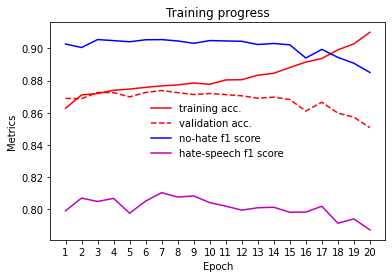

In [40]:
plots([history.history['categorical_accuracy'],
       history.history['val_categorical_accuracy'],
       model.mc.val_f1s0,
       model.mc.val_f1s1],
      ['training acc.', 'validation acc.', 'no-hate f1 score', 'hate-speech f1 score'],
      ['-r', '--r', 'b', 'm'],
      title='Training progress', file_name='results/en_conv/train_progress.png')

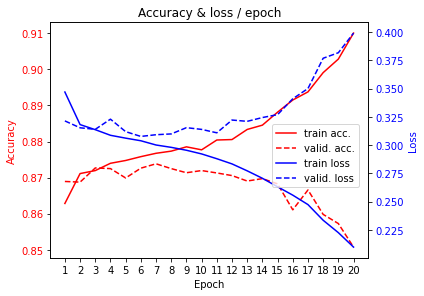

In [41]:
twinx_plot(history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
           history.history['loss'], history.history['val_loss'],
          x_label='Epoch', y1_label='Accuracy', y2_label='Loss', title='Accuracy & loss / epoch',
          file_name='results/en_conv/acc_loss.png')

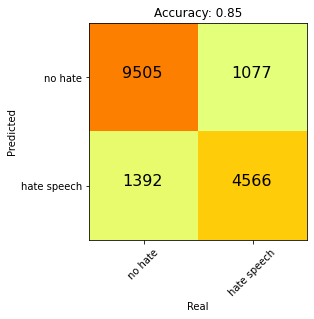

In [42]:
confusion_matrix_plot(conf_mat, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='Accuracy: {}'.format(round(acc, 2)),
                      file_name='results/en_conv/cm.png')

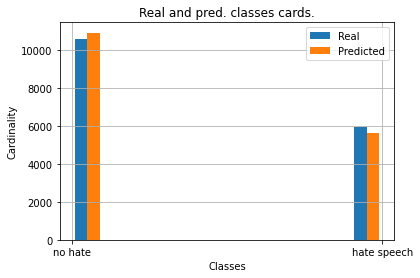

In [43]:
class_distribution_hist(y_true, y_pred, cls=classes,
                        x_label='Classes', y_label='Cardinality', title='Real and pred. classes cards.',
                        file_name='results/en_conv/cards.png')

In [44]:
with open('hsd/DavidsonEtAl/perfect_data.pkl', 'rb') as f:
    texts, _ = pickle.load(f)
texts = texts[int(SPLIT_RATIO*len(texts)):]

indices = [6, 10, 19, 26, 27, 28, 29, 164]
test_cases = []
for i, (t, p, l) in enumerate(zip(texts, y_pred, y_true)):
    if i in indices:
        test_cases.append({'Text': t, 'Prediction': p.numpy(), 'Label': l.numpy()})

In [45]:
def test_cases_board(test_cases, title, file_name=None):
    h = 20
    n = len(test_cases)
    fig, axis = plt.subplots(1, 1, figsize=(16., n*3.2))
    axis.axis('off')
    axis.set_xlim([0, 100])
    axis.set_ylim([0, n*h])
    axis.plot([0, 100], [0, 0], color='k')
    axis.plot([0, 0], [0, n*h], color='k')
    axis.plot([100, 100], [0, n*h], color='k')
    
    for i in range(n):
        axis.annotate('Tweet text:', xy=(4, 16 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        text = u'{}'.format(test_cases[i]['Text'].replace('\n', ''))
        text = '\n'.join([text[j:j+int(len(text)/3)] for j in range(0, len(text), int(len(text)/3))])
        axis.annotate(text, xy=(4, 7 + i*h), xycoords='data', size=15)
        
        axis.annotate('Prediction:', xy=(4, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        pred = 'no hate' if test_cases[i]['Prediction'] == 0 else 'hate speech'
        pred_color = 'b' if pred == 'no hate' else 'm'
        axis.annotate(pred, xy=(15, 4 + i*h), xycoords='data', size=15, color=pred_color)
        
        axis.annotate('Label:', xy=(27, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        label = 'no hate' if test_cases[i]['Label'] == 0 else 'hate speech'
        label_color = 'b' if label == 'no hate' else 'm'
        axis.annotate(label, xy=(34, 4 + i*h), xycoords='data', size=15, color=label_color)
        
        axis.annotate('Result:', xy=(50, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        reason = 'OK' if pred == label else '1-st type error' if pred == 'no hate' else '2-nd type error'
        reason_color = 'g' if reason == 'OK' else 'r'
        axis.annotate(reason, xy=(57, 4 + i*h), xycoords='data', size=15, color=reason_color)
        
        axis.plot([0, 100], [20 + i*h, 20 + i*h], color='k')
    
    
    plt.title(title)
    if file_name:
        plt.savefig(file_name)
    plt.show()

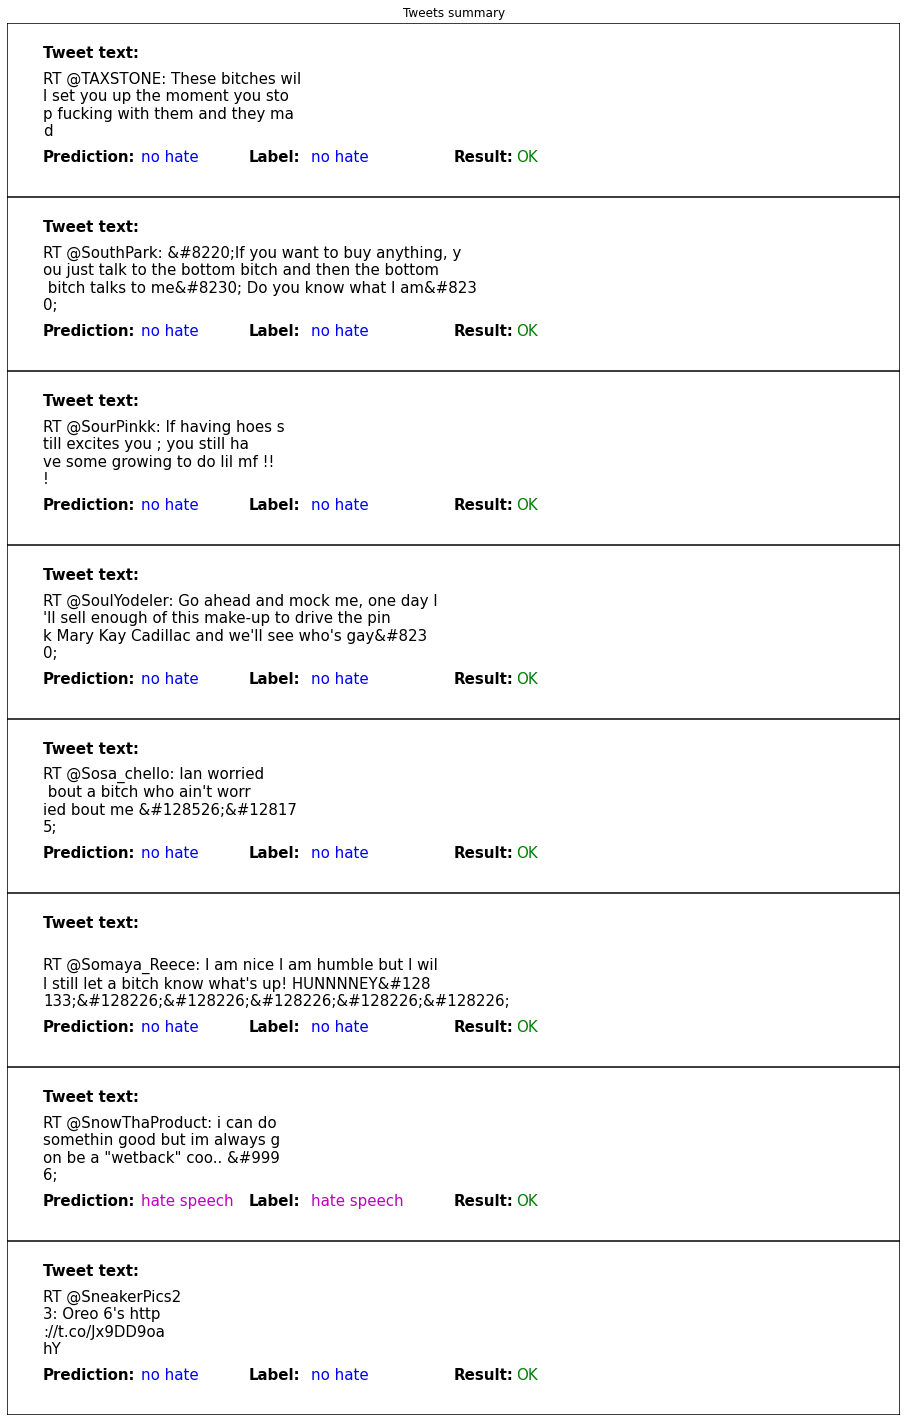

In [46]:
test_cases_board(test_cases, title='Tweets summary', file_name='results/en_conv/tweets_summary.png')

# Hate Speech Detector - EN - Convolutional model testing

## Load test features, predict classes, assign tweets and save to .csv

In [ ]:
# with open('tests/en_conv/assigned_labels.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerow(['Label'])
    
#     t = tqdm(sorted(glob.glob('tests/en_conv/X*')))
#     for file_name in t:
#         t.set_postfix_str(file_name)
#         archive = dir_archive(file_name, {}, cached=True)
#         archive.load()

#         test_features = archive['features']
#         sh = test_features.shape
#         test_features =  test_features.reshape(sh[0], sh[1], sh[2]/3, 3)
        
#         test_predictions = model.predict(test_features)
#         test_labels = tf.argmax(test_predictions, axis=1).numpy()
        
#         for tl in test_labels:
#             writer.writerow([tl])